# GFA Dark Calibration

GFA calibrations should normally be updated in the following sequence: zeros, flats, gains.

This notebook should be run using a DESI kernel, e.g. `DESI master`.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import json
import collections
from pathlib import Path

In [4]:
import scipy.interpolate
import scipy.stats

In [5]:
import fitsio

Install / upgrade the `desietcimg` package:

In [6]:
try:
    import desietcimg
    print('desietcimg already installed')
except ImportError:
    print('Installing desietcimg...')
    !{sys.executable} -m pip install --user git+https://github.com/dkirkby/desietcimg

desietcimg already installed


In [7]:
upgrade = False
if upgrade:
    print('Upgrading desietcimg...')
    !{sys.executable} -m pip install --upgrade --user git+https://github.com/dkirkby/desietcimg

In [8]:
import desietcimg.util
import desietcimg.plot
import desietcimg.gfa

NERSC configuration:

In [9]:
assert os.getenv('NERSC_HOST', False)

In [10]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
assert ROOT.exists()

Initial GFA calibration:

In [11]:
CALIB = Path('/global/cscratch1/sd/dkirkby/GFA_calib.fits')
assert CALIB.exists()

Directory for saving plots:

In [12]:
plotdir = Path('darkcal')
plotdir.mkdir(exist_ok=True)

## Process Dome Dark Sequences

In [13]:
darks = {}

In [14]:
def process_darks(night, first, last):
    files = desietcimg.util.find_files(
        ROOT / str(night) / '{N}/gfa-{N}.fits.fz', min=first, max=last,
        partial_match_is_error=False)
    nexp = len(files)
    print('Processing {0} exposures from {1}...'.format(nexp, night))
    GFA = desietcimg.gfa.GFACamera(calib_name=str(CALIB))
    ngfa = len(GFA.gfa_names)
    mjd = np.empty((ngfa, nexp))
    temp = np.empty((ngfa, nexp))
    sigmed = np.empty((ngfa, nexp))
    for k, gfa in enumerate(GFA.gfa_names):
        raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', 'MJD-OBS', 'GCCDTEMP', hdu=gfa)
        # Check that all exposures have the same length.
        texp = meta['EXPTIME'][0]
        assert np.all(meta['EXPTIME'] == texp)
        if k == 0:
            print('Exposure time is {0:.1f}s'.format(texp))
        # Save this camera's timestamps and temperatures.
        mjd[k] = meta['MJD-OBS']
        temp[k] = meta['GCCDTEMP']
        # Calculate and save this camera's median signal in elec/s in each exposure.
        GFA.setraw(raw, name=gfa)
        sigmed[k] = np.median(GFA.data / texp, axis=(1, 2))
    if first in darks:
        print('Replacing previous results')
    darks[first] = dict(
        night=night, last=last, nexp=nexp, texp=texp,
        mjd=mjd, temp=temp, sigmed=sigmed)

In [15]:
%time process_darks(20191105, 24514, 24713)

Processing 200 exposures from 20191105...
Exposure time is 5.0s
CPU times: user 2min 44s, sys: 38.2 s, total: 3min 22s
Wall time: 6min 32s


In [16]:
%time process_darks(20191109, 25742, 25777)

Processing 36 exposures from 20191109...
Exposure time is 5.0s


CPU times: user 28.6 s, sys: 6.62 s, total: 35.3 s
Wall time: 41.6 s


In [17]:
%time process_darks(20191109, 25838, 25937)

Processing 100 exposures from 20191109...
Exposure time is 5.0s


CPU times: user 1min 22s, sys: 19.9 s, total: 1min 42s
Wall time: 3min 20s


In [18]:
%time process_darks(20191110, 25988, 26087)

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 19s, sys: 14.2 s, total: 1min 33s
Wall time: 3min 25s


In [19]:
%time process_darks(20191110, 26088, 26192) # includes some spectrograph zeros

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 20s, sys: 16.9 s, total: 1min 37s
Wall time: 3min 26s


In [20]:
%time process_darks(20191110, 26439, 26538)

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 17s, sys: 11.4 s, total: 1min 28s
Wall time: 2min 28s


In [21]:
%time process_darks(20191110, 26584, 26684) # 26604 is a 900s spectrograph dark

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 18s, sys: 13.1 s, total: 1min 31s
Wall time: 2min 47s


In [22]:
%time process_darks(20191110, 26730, 26829)

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 19s, sys: 15.7 s, total: 1min 35s
Wall time: 2min 10s


In [23]:
%time process_darks(20191110, 26859, 26958)

Processing 100 exposures from 20191110...
Exposure time is 5.0s


CPU times: user 1min 22s, sys: 20.5 s, total: 1min 42s
Wall time: 2min 18s


In [24]:
%time process_darks(20191115, 28420, 28519)

Processing 100 exposures from 20191115...
Exposure time is 5.0s


CPU times: user 1min 20s, sys: 14.7 s, total: 1min 34s
Wall time: 3min 33s


## Bin Dark Current and Temperature During Each Sequence

In [38]:
def bin_time_dependence(first, ntbins='auto', dtmin=None, dtmax=None, bad='', save=None):
    ngfa = len(desietcimg.gfa.GFACamera.gfa_names)
    badgfas = bad.split(',')
    data = darks[first]
    mjd, temp, sigmed = data['mjd'], data['temp'], data['sigmed']
    # Convert to elapsed minutes
    dt = (mjd - mjd.min()) * 24 * 60
    # Determine the elapsed time binning to use.
    if ntbins == 'auto':
        ntbins = int(round(data['nexp'] / 15))
    if dtmin is None:
        dtmin = 0
    if dtmax is None:
        dtmax = 1.001 * dt.max()
    print('Using {0} bins for {1}-{2} on {3}'.format(ntbins, first, data['last'], data['night']))
    # Define equally spaced bins in elapsed time.
    dtbins = np.linspace(dtmin, dtmax, ntbins + 1)
    dtgrid = 0.5 * (dtbins[1:] + dtbins[:-1])
    idx = np.digitize(dt, dtbins) - 1
    # Calculate summaries in each bin.
    dtsum = np.empty((ngfa, ntbins))
    tempsum = np.empty((ngfa, ntbins))
    sigmedsum = np.empty((ngfa, ntbins))
    for j in range(ntbins):
        for k in range(ngfa):
            sel = (idx[k] == j)
            dtsum[k, j] = np.mean(dt[k, sel])
            tempsum[k, j] = np.median(temp[k, sel])
            sigmedsum[k, j] = np.median(sigmed[k, sel])
            
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][k]
        ax[0].plot(dt[k], temp[k], '.', c=c, alpha=0.2)
        ax[1].plot(dt[k], sigmed[k], '.', c=c, alpha=0.2)
        fmt = 'x--' if gfa in badgfas else 'o-'
        ax[0].plot(dtsum[k], tempsum[k], fmt, c=c, label=gfa)
        ax[1].plot(dtsum[k], sigmedsum[k], fmt, c=c, label=gfa)
    for axis in ax:
        axis.legend(ncol=5)
        axis.set_xlim(dt.min(), dt.max())
    ax[0].set_ylabel('Median CCD Temperature [C]')
    ax[1].set_ylabel('Median Dark Current [elec/s]')
    ax[1].set_xlabel('Elapsed Time $t$ [min]')
    plt.tight_layout()
    if save:
        plt.savefig(save.format(first=first))
    
    if 'dtsum' in data:
        print('Replacing previous binned results')
    data['dtsum'] = dtsum
    data['tempsum'] = tempsum
    data['sigmedsum'] = sigmedsum
    data['bad'] = badgfas

If the data for some GFAs looks bad, add it to the optional `bad` list and rerun. Set the number of time bins manually if needed.

Using 13 bins for 24514-24713 on 20191105
Replacing previous binned results


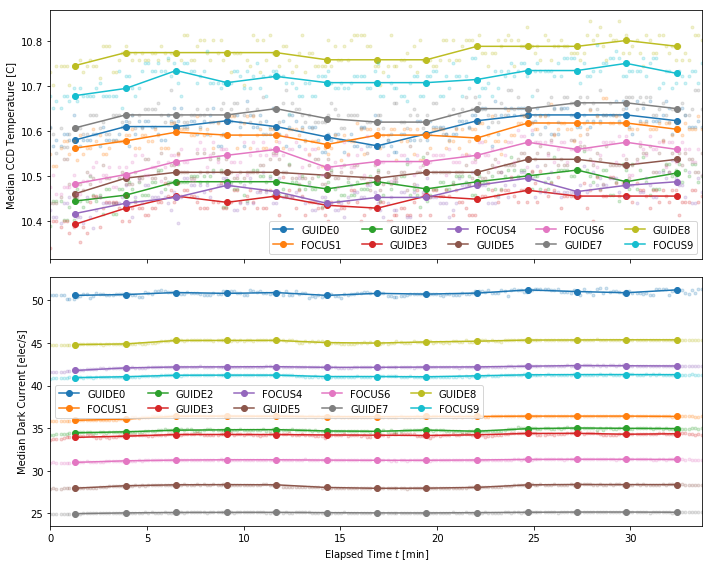

In [40]:
bin_time_dependence(24514, save=str(plotdir / 'dark_{first}.png'))

Using 3 bins for 25742-25777 on 20191109
Replacing previous binned results


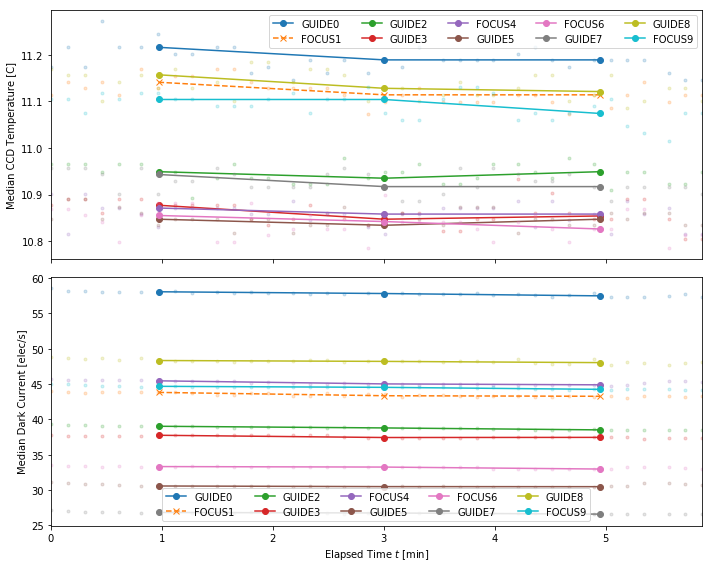

In [41]:
bin_time_dependence(25742, ntbins=3, bad='FOCUS1', save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 25838-25937 on 20191109
Replacing previous binned results


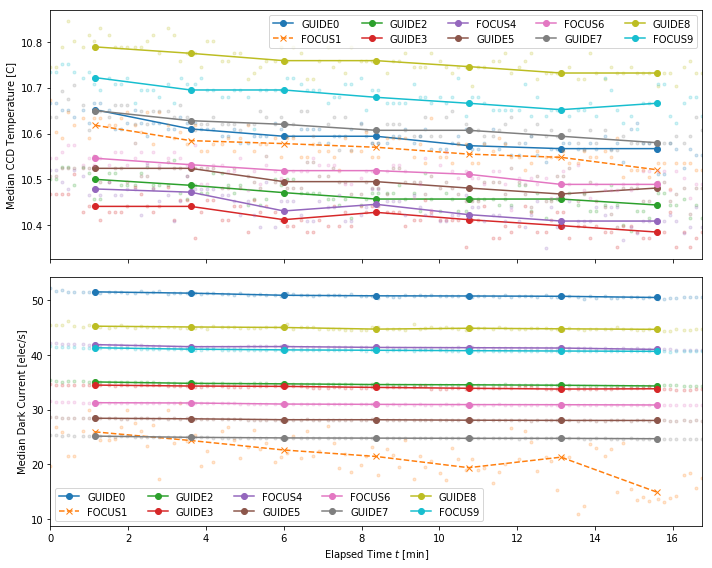

In [42]:
bin_time_dependence(25838, bad='FOCUS1', save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 25988-26087 on 20191110
Replacing previous binned results


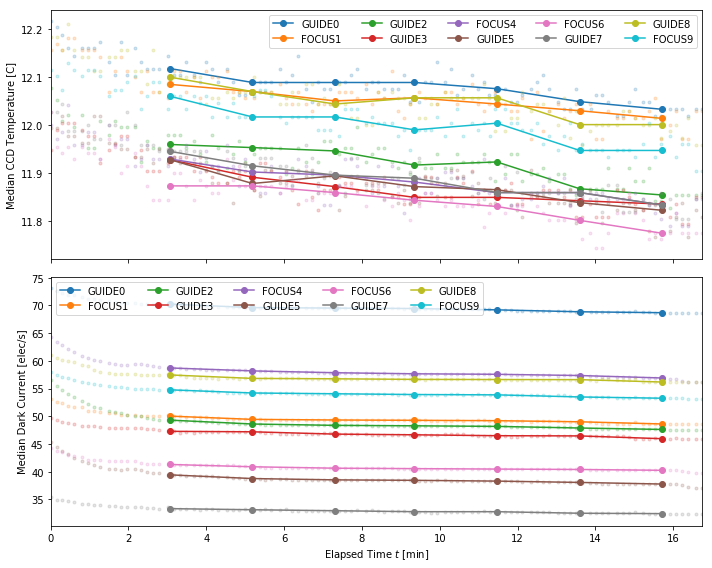

In [43]:
bin_time_dependence(25988, dtmin=2, save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 26088-26192 on 20191110
Replacing previous binned results


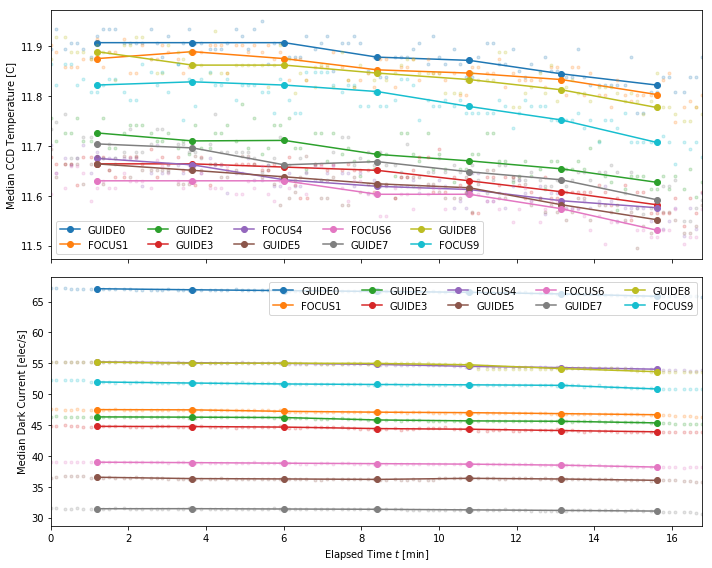

In [44]:
bin_time_dependence(26088, save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 26439-26538 on 20191110
Replacing previous binned results


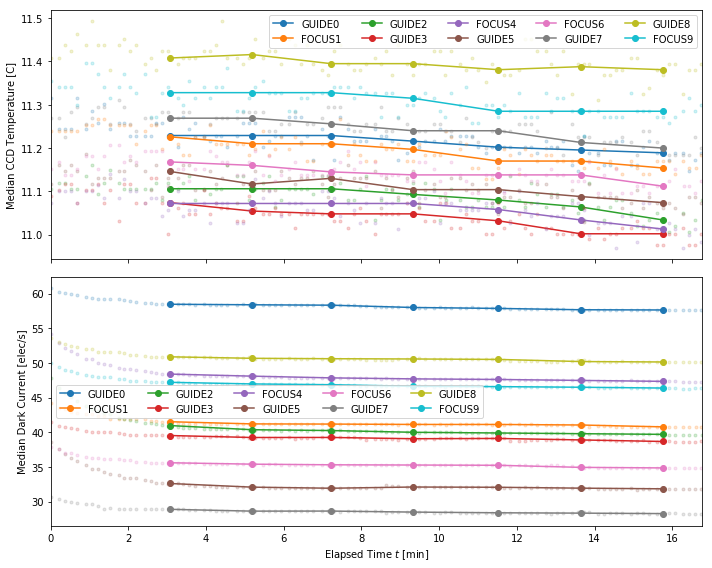

In [45]:
bin_time_dependence(26439, dtmin=2, save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 26584-26684 on 20191110
Replacing previous binned results


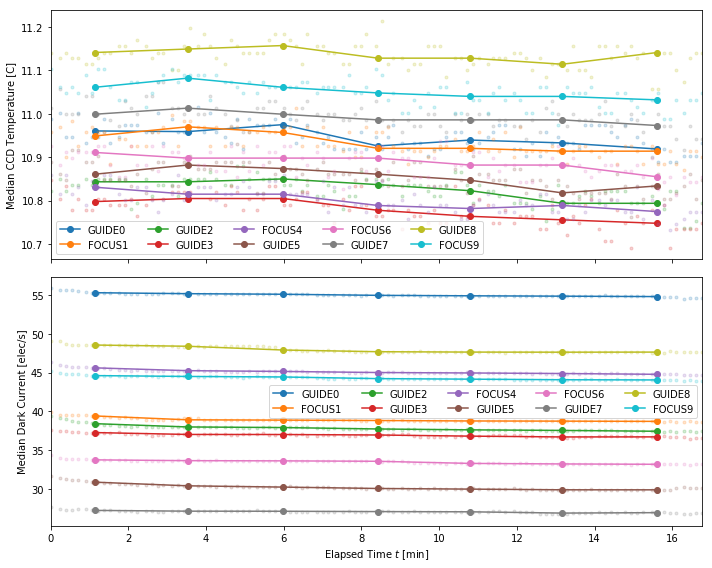

In [46]:
bin_time_dependence(26584, save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 26730-26829 on 20191110
Replacing previous binned results


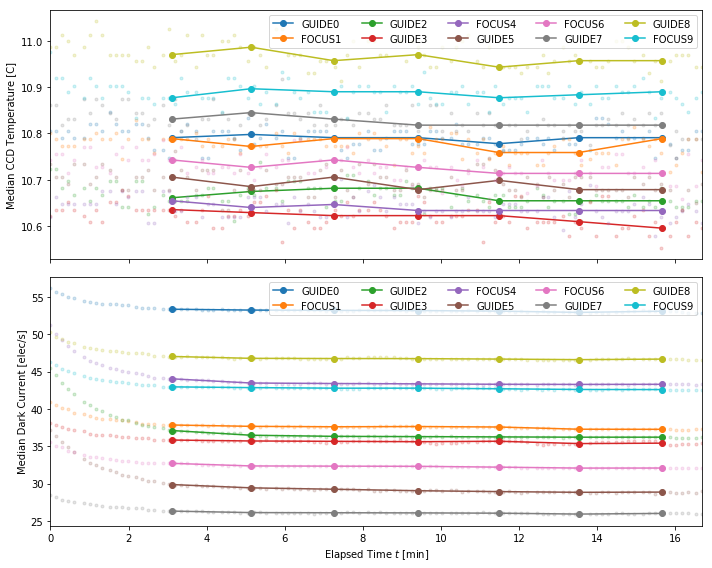

In [47]:
bin_time_dependence(26730, dtmin=2, save=str(plotdir / 'dark_{first}.png'))

Using 7 bins for 26859-26958 on 20191110
Replacing previous binned results


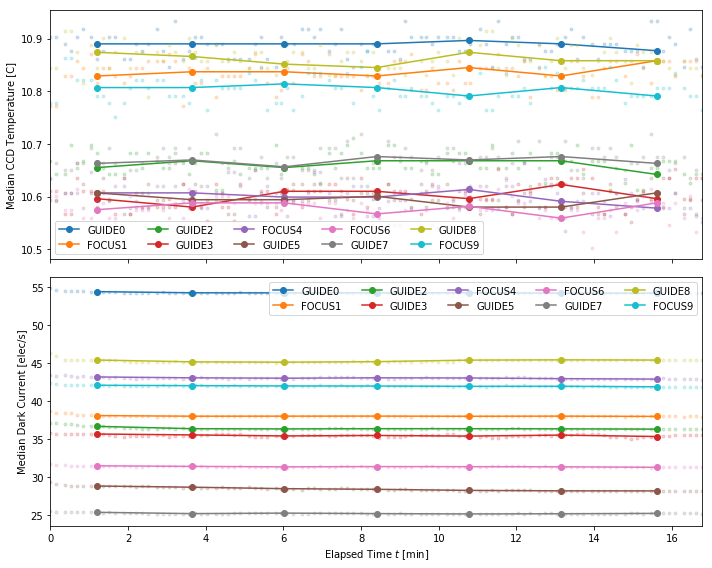

In [48]:
bin_time_dependence(26859, save=str(plotdir / 'dark_{first}.png'))

Using 6 bins for 28420-28519 on 20191115
Replacing previous binned results


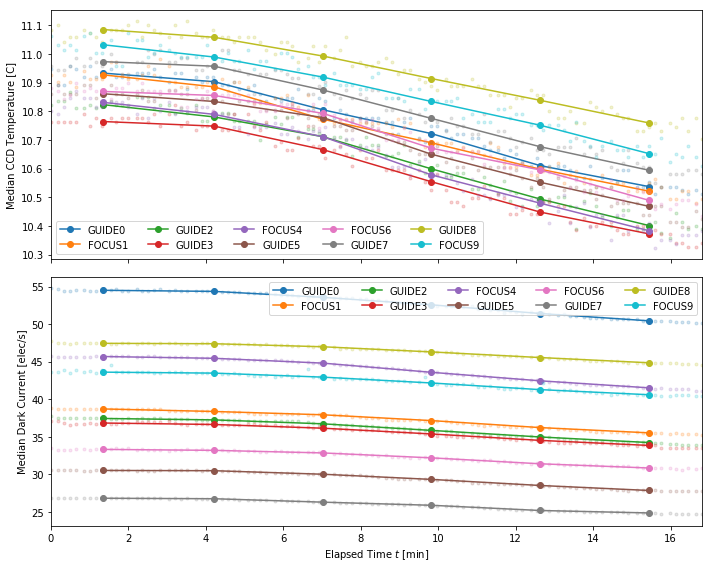

In [49]:
bin_time_dependence(28420, ntbins=6, save=str(plotdir / 'dark_{first}.png'))

## Fit Temperature Dependence

Fit the dark-current temperature dependence using the Arrhenius law (see e.g., [here](https://doi.org/10.1117/12.463446)):
$$
    i_d(T) = i_0 \exp\left( \frac{\Delta E}{k(T + 273.15)} \right)
$$
where $T$ is the `GCCDTEMP` FITS header value in degrees Celsius.

In [90]:
def predict(Tabs, i0, c):
    return i0 * np.exp(-c / Tabs)

In [91]:
def nll(theta, Tabs, S):
    i0, c = theta
    Spred = predict(Tabs, i0, c)
    return 0.5 * np.sum((S - Spred) ** 2)

In [92]:
def fit_time_dependence(TREF=11, save='GFA_temp_fit.png'):
    results = {}
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        ax = axes[k // 2, k % 2]
        # Concatenate the binned temperature and dark current values to fit.
        Tvec, Svec = [], []
        for first, data in darks.items():
            T = data['tempsum'][k]
            S = data['sigmedsum'][k]
            if gfa in data['bad']:
                print('Ignoring {0} from {1}-{2} on {3}.'.format(gfa, first, data['last'], data['night']))
                fmt = 'x'
                bad = True
            else:
                fmt = '+'
                bad = False
            ax.plot(T, S, fmt, label=str(first))
            if not bad:
                Tvec.append(T)
                Svec.append(S)
        T = np.concatenate(Tvec)
        S = np.concatenate(Svec)
        # Perform a linear fit.
        p1, p0 = np.polyfit(T - TREF, S, deg=1)
        # Calculate and plot the best-fit prediction.
        xline = np.percentile(T, (0, 100))
        yline = p0 + p1 * (xline - TREF)
        ax.plot(xline, yline, 'k:', alpha=0.5)
        ax.set_ylim(0.95 * yline[0], 1.05 * yline[1])        
        # Convert the linear fit results to initial values for the non-linear fit.
        T0 = 273.15
        c = p1 / p0 * (TREF + T0) ** 2
        i0 = p0 * np.exp(c / (TREF + T0))
        theta0 = (i0, c)
        # Perform the non-linear fit.
        result = scipy.optimize.minimize(
            nll, theta0, args=(T + T0, S),
            method='BFGS', jac='2-point', options=dict(
                maxiter=10000, gtol=5e-5, disp=False))
        if not result.success:
            print('Falling back to Nelder-Mead')
            result = scipy.optimize.minimize(
                nll, theta0, args=(T + T0, S),
                method='Nelder-Mead', options=dict(
                    maxiter=10000, xatol=1e-3, fatol=1e-3, disp=False))
            assert result.success
        i0, c = result.x
        # Plot the non-linear fit.
        Tnl = np.linspace(10.25, 12.25, 100)
        Spred = predict(Tnl + T0, i0, c)
        ax.plot(Tnl, Spred, 'k-', lw=4, alpha=0.1)
        # Save the linear and non-linear fit results.
        results[gfa] = dict(TREF=TREF, TCOEF=p1 / p0, IREF=p0, I0=i0, C=c)
        
        if k in (8, 9):
            ax.set_xlabel('GFA CCD Temperature [C]')
        title = '{0} {1:.1f} e/s {2:+.1f}%/C'.format(gfa, p0, 100 * p1 / p0)
        ax.legend(ncol=2, title=title)
        ax.set_ylabel('Dark Current [e/s]')
        ax.axvline(TREF, ls=':', c='k')
    plt.tight_layout()
    if save:
        plt.savefig(save)    
    return results

Ignoring FOCUS1 from 25742-25777 on 20191109.
Ignoring FOCUS1 from 25838-25937 on 20191109.


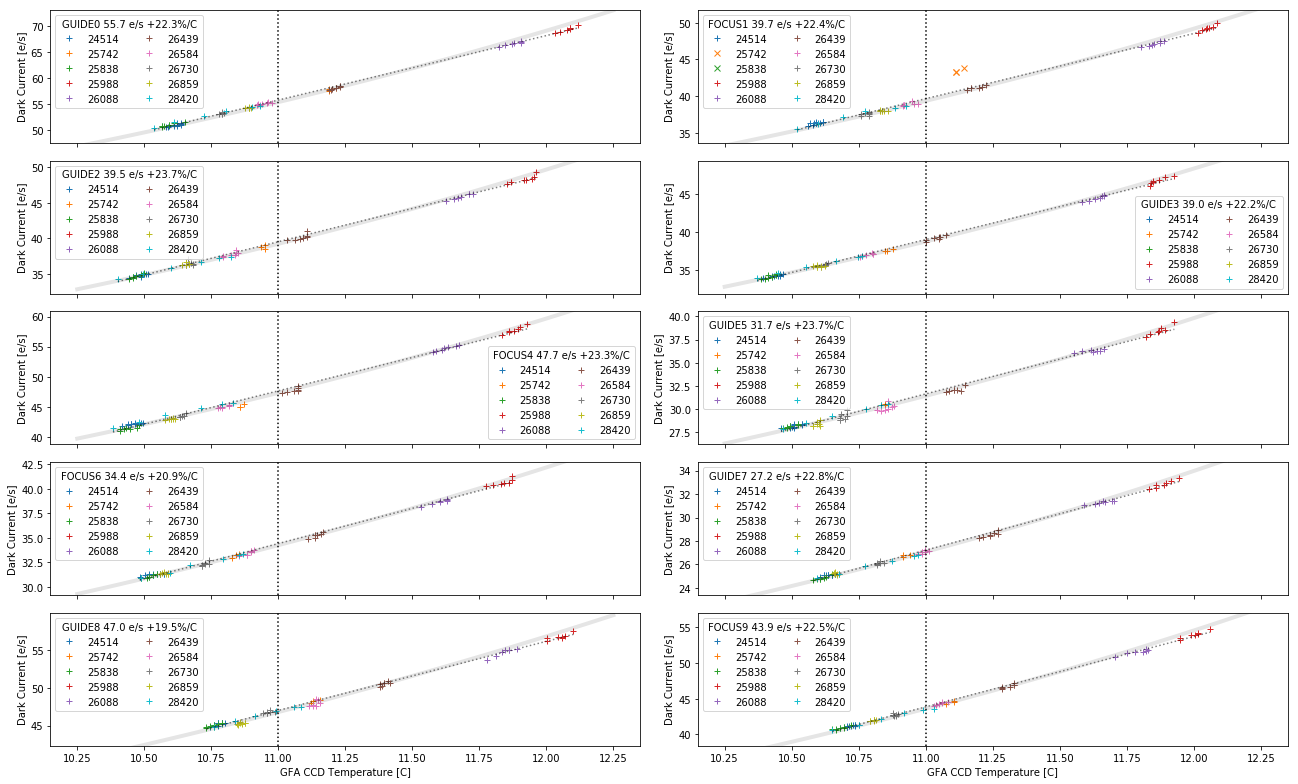

In [93]:
fitresults = fit_time_dependence()

In [94]:
repr(fitresults)

"{'GUIDE0': {'TREF': 11, 'TCOEF': 0.22261910047916852, 'IREF': 55.728987053109535, 'I0': 1.6532617086895336e+29, 'C': 17976.568817017935}, 'FOCUS1': {'TREF': 11, 'TCOEF': 0.2238448823320409, 'IREF': 39.65590488572293, 'I0': 1.6666164279032004e+29, 'C': 18075.665891648583}, 'GUIDE2': {'TREF': 11, 'TCOEF': 0.23703701836390673, 'IREF': 39.53685571674017, 'I0': 7.055089500147693e+30, 'C': 19140.77658038116}, 'GUIDE3': {'TREF': 11, 'TCOEF': 0.22228804279046271, 'IREF': 38.97465258681179, 'I0': 1.0524188308230834e+29, 'C': 17949.693331484643}, 'FOCUS4': {'TREF': 11, 'TCOEF': 0.2326699376858498, 'IREF': 47.66068231052711, 'I0': 2.4589066290084404e+30, 'C': 18788.062405670666}, 'GUIDE5': {'TREF': 11, 'TCOEF': 0.2368110818866002, 'IREF': 31.655114357546008, 'I0': 5.297398520510958e+30, 'C': 19122.303169241117}, 'FOCUS6': {'TREF': 11, 'TCOEF': 0.20934012548886696, 'IREF': 34.41085825124004, 'I0': 2.345670546209627e+27, 'C': 16903.71288661386}, 'GUIDE7': {'TREF': 11, 'TCOEF': 0.22775144593630675,

## Build Master Dark Images

Build a master dark for each GFA using the same exposures used in the temperature fit.  Each exposure is corrected to TREF using a smoothed temperature estimate to calculate a median of corrected exposures from each sequence that is immune to cosmics.  Finally, the median dark images from each sequence are averaged for the final master dark.

In [103]:
def build_master_dark():
    master_dark = {}
    GFA = desietcimg.gfa.GFACamera(calib_name='/global/cscratch1/sd/dkirkby/GFA_calib.fits')
    # Loop over GFAs
    for k, gfa in enumerate(GFA.gfa_names):
        # Loop over dark sequences.
        nseq = 0
        median_stack = np.zeros((2 * GFA.nampy, 2 * GFA.nampx), np.float32)
        for first, data in darks.items():
            # Select exposures used in the fit.
            if gfa in data['bad']:
                continue
            dtsum = data['dtsum'][k]
            binsize = dtsum[1] - dtsum[0]
            dtlo = dtsum[0] - 0.5 * binsize
            dthi = dtsum[-1] + 0.5 * binsize
            mjd = data['mjd']
            dt = (mjd[k] - mjd.min()) * 24 * 60
            sel = (dt >= dtlo) & (dt <= dthi)
            if k == 0:
                print('Using {0} / {1} exposures from {2}'
                      .format(np.count_nonzero(sel), len(sel), first))
            # Use linear interpolation to correct each exposure to TREF.
            Tmodel = scipy.interpolate.interp1d(
                dtsum, data['tempsum'][k], kind='linear',
                copy=False, assume_sorted=True, fill_value='extrapolate')
            Tfit = Tmodel(dt)
            TREF, I0, C = fitresults[gfa]['TREF'], fitresults[gfa]['I0'], fitresults[gfa]['C']
            T0 = 273.15
            S0 = predict(TREF + T0, I0, C)
            Tcorrection = S0 / predict(Tfit + T0, I0, C)
            # Load exposure data for this sequence.
            night = data['night']
            last = data['last']
            files = desietcimg.util.find_files(
                ROOT / str(night) / '{N}/gfa-{N}.fits.fz', min=first, max=last,
                partial_match_is_error=False)
            raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', 'MJD-OBS', 'GCCDTEMP', hdu=gfa)
            # Check that all exposures have the same length.
            texp = meta['EXPTIME'][0]
            assert np.all(meta['EXPTIME'] == texp)
            # Subtract bias and apply gain.
            GFA.setraw(raw, name=gfa)
            # Correct each exposure to TREF and convert to elec/s.
            GFA.data *= Tcorrection.reshape(GFA.nexp, 1, 1) / texp
            # Take the median of the selected exposures normalized 
            median_stack += np.median(GFA.data[sel], axis=0)
            nseq += 1
        # Average the medians corrected to TREF from each sequence.
        master_dark[gfa] = median_stack / nseq
        print('{0} median dark current: {1:.3f} elec/s'.format(gfa, np.median(master_dark[gfa])))
    return master_dark

In [104]:
%time master_dark = build_master_dark()

Using 200 / 200 exposures from 24514
Using 36 / 36 exposures from 25742
Using 100 / 100 exposures from 25838
Using 87 / 100 exposures from 25988
Using 100 / 100 exposures from 26088
Using 88 / 100 exposures from 26439
Using 100 / 100 exposures from 26584
Using 86 / 100 exposures from 26730
Using 100 / 100 exposures from 26859
Using 100 / 100 exposures from 28420
GUIDE0 median dark current: 54.759 elec/s
FOCUS1 median dark current: 38.319 elec/s
GUIDE2 median dark current: 39.092 elec/s
GUIDE3 median dark current: 38.310 elec/s


FOCUS4 median dark current: 47.154 elec/s


GUIDE5 median dark current: 31.009 elec/s
FOCUS6 median dark current: 33.474 elec/s
GUIDE7 median dark current: 26.108 elec/s


GUIDE8 median dark current: 46.557 elec/s


FOCUS9 median dark current: 42.557 elec/s
CPU times: user 21min 23s, sys: 4min 33s, total: 25min 56s
Wall time: 45min 1s


## Save Updated Calibrations

In [105]:
desietcimg.gfa.save_calib_data('GFA_calib_dark.fits', master_dark=master_dark, tempfit=fitresults)

Using default master_zero
Using default pixel_mask
Using default readnoise
Using default gain
Saved GFA calib data to GFA_calib_dark.fits.


Make this updated calibration available:

In [106]:
!cp GFA_calib_dark.fits {CALIB}

## Sensor Temperature Measurement

How accurate are the `GCCDTEMP` values in the GFA FITS headers?  Compare with the smoothed temperature models obtained above.

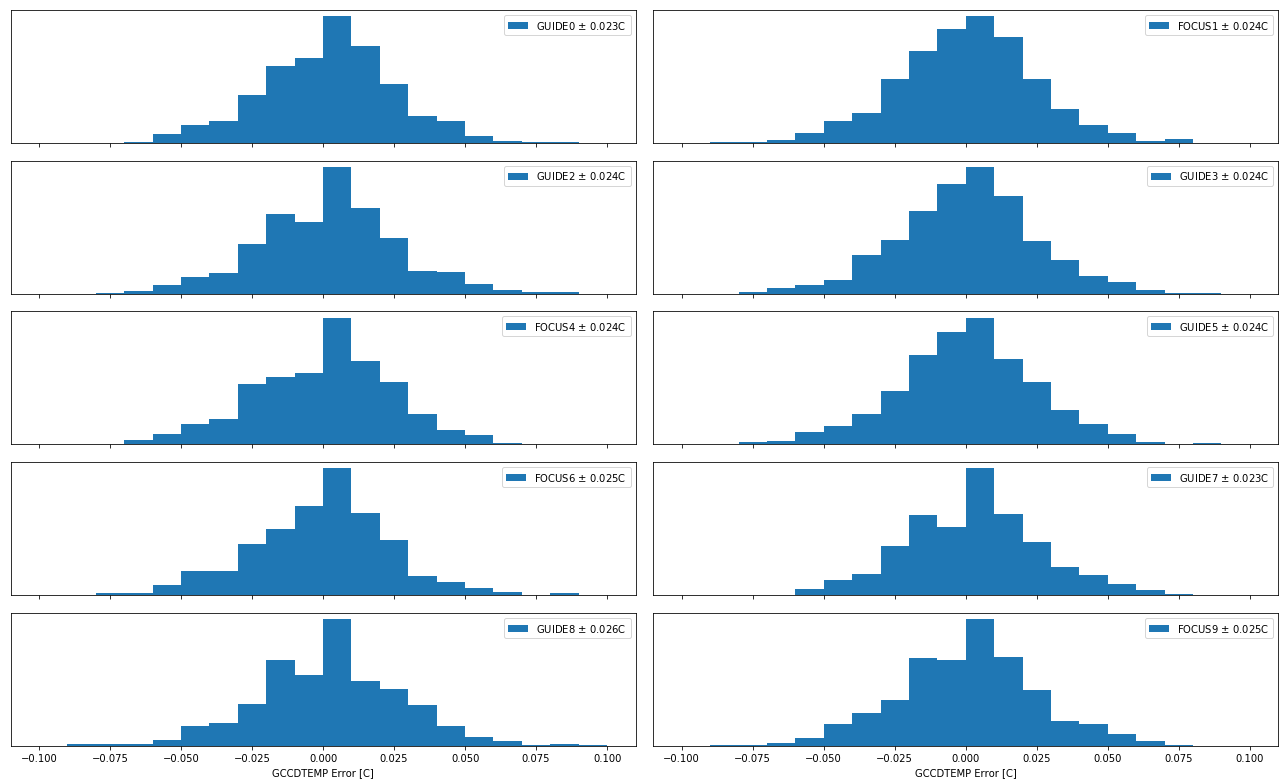

In [107]:
def plot_temp_residuals(save='GFA_temp_accuracy.png'):
    results = {}
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    bins = np.linspace(-0.1, 0.1, 21)
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        ax = axes[k // 2, k % 2]
        Tresidual = []
        # Loop over dark sequences.
        for first, data in darks.items():
            # Extract the timestamps and header GCCDTEMP values for each exposure.
            mjd = data['mjd']
            dt = (mjd[k] - mjd.min()) * 24 * 60
            T = data['temp'][k]
            # Build a linear model for temperature vs time.
            Tmodel = scipy.interpolate.interp1d(
                data['dtsum'][k], data['tempsum'][k], kind='linear',
                copy=False, assume_sorted=True, fill_value='extrapolate')
            # Calculate actual - model residuals for each exposure.
            Tresidual.append(T - Tmodel(dt))
        Tresidual = np.concatenate(Tresidual)
        Terror = np.std(Tresidual)
        label = '{0} $\pm$ {1:.3f}C'.format(gfa, Terror)
        ax.hist(Tresidual, bins=bins, histtype='stepfilled', density=True, label=label)
        ax.legend()
        ax.set_yticks([])
        if k in (8, 9):
            ax.set_xlabel('GCCDTEMP Error [C]')
    plt.tight_layout()
    if save:
        plt.savefig(save)    

plot_temp_residuals()